In [1]:
import numpy as np
import pandas as pd
from typing import Optional, Tuple
import sys

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")


import shutil
import warnings
import pickle

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

from nn_functions import surrogate
from moving_average import moving_average_1d
import copy
from GAMMA_obj_temp_depth import GAMMA_obj

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss, TiDE_forward


cuda is available


In [2]:
from policy import PolicyNN
model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)

model.load_state_dict(torch.load("policy_model_0630_onlytracking_3L_1024H.pth", map_location="cpu"))


<All keys matched successfully>

In [3]:
INPUT_DATA_DIR = "data"
SIM_DIR_NAME = "single_track_square"
BASE_LASER_FILE_DIR = "laser_power_profiles/csv"
CLOUD_TARGET_BASE_PATH = "result"
solidus_temp = 1600
window = 50
sim_interval = 5
init_runs = 50 #50 

GAMMA_class = GAMMA_obj(INPUT_DATA_DIR, SIM_DIR_NAME, BASE_LASER_FILE_DIR, CLOUD_TARGET_BASE_PATH, solidus_temp, window, init_runs, sim_interval)
init_avg = GAMMA_class.run_initial_steps()
init_avg = torch.tensor(init_avg,dtype=torch.float32)[:,-window:] # shape = [2,50]

100%|██████████| 250/250 [00:05<00:00, 44.87it/s]


In [4]:
df_one_print = pd.read_csv('single_track_ref.csv')

loc_X_list = df_one_print["X"].to_numpy().reshape(-1,1)
loc_Y_list = df_one_print["Y"].to_numpy().reshape(-1,1)
loc_Z_list = df_one_print["Z"].to_numpy().reshape(-1,1)
dist_X_list = df_one_print["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y_list = df_one_print["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
scan_spd_list = df_one_print["scanning_speed"].to_numpy().reshape(-1,1)

# laser on/off indicator
laser_on_off = df_one_print["laser_power_number"].to_numpy().reshape(-1,1)

# laser power
laser_power_ref = torch.tensor(df_one_print["Laser_power"].to_numpy().reshape(-1,1),dtype=torch.float32)
laser_power_past = laser_power_ref[:window]

# fix_covariates = torch.tensor(np.concatenate((loc_X_list,loc_Y_list,loc_Z_list,dist_X_list,dist_Y_list,scan_spd_list, laser_on_off),axis=1),dtype=torch.float32)
fix_covariates = torch.tensor(np.concatenate((loc_Z_list,dist_X_list,dist_Y_list),axis=1),dtype=torch.float32)

# temporary ref
# apply moving average for mp temp
mp_temp_raw = df_one_print["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp

mp_temp_ref = torch.tensor(mp_temp,dtype=torch.float32)

In [5]:
print("laser_power_ref shape:", laser_power_ref.size())
print("laser_power_ref min:", torch.min(laser_power_ref).item())
print("laser_power_ref max:", torch.max(laser_power_ref).item())

print("fix_covariates shape:", fix_covariates.size())

col_min = torch.min(fix_covariates, dim=0).values
col_max = torch.max(fix_covariates, dim=0).values

print("fix_covariates column-wise min:", col_min.cpu().numpy())
print("fix_covariates column-wise max:", col_max.cpu().numpy())

nan_indices = torch.nonzero(torch.isnan(mp_temp_ref), as_tuple=True)[0]
print("NaN indices:", nan_indices)

valid_values = mp_temp_ref[~torch.isnan(mp_temp_ref)]

print("mp_temp_ref (valid) min:", valid_values.min().item())
print("mp_temp_ref (valid) max:", valid_values.max().item())



laser_power_ref shape: torch.Size([6295, 1])
laser_power_ref min: 531.5235595703125
laser_power_ref max: 600.7783203125
fix_covariates shape: torch.Size([6295, 3])
fix_covariates column-wise min: [0.   0.75 0.75]
fix_covariates column-wise max: [ 7.5 20.  20. ]
NaN indices: tensor([6292, 6294])
mp_temp_ref (valid) min: 436.1014099121094
mp_temp_ref (valid) max: 3834.751220703125


In [6]:
import torch

# values from user
x_min = torch.tensor([[0.0, 0.75, 0.75, 504.26]], dtype=torch.float32).to(device)
x_max = torch.tensor([[7.5, 20.0, 20.0, 732.298]], dtype=torch.float32).to(device)

y_min = torch.tensor([[436.608, -0.559]], dtype=torch.float32).to(device)
y_max = torch.tensor([[4509.855, 0.551]], dtype=torch.float32).to(device)


In [7]:
def normalize_x(x, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 2 * (x - x_min_selected) / (x_max_selected - x_min_selected) - 1

def inverse_normalize_x(x_norm, dim_id):
    x_min_selected = x_min[0, dim_id]
    x_max_selected = x_max[0, dim_id]
    return 0.5 * (x_norm + 1) * (x_max_selected - x_min_selected) + x_min_selected

def normalize_y(y, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 2 * (y - y_min_selected) / (y_max_selected - y_min_selected) - 1

def inverse_normalize_y(y_norm, dim_id):
    y_min_selected = y_min[0, dim_id]
    y_max_selected = y_max[0, dim_id]
    return 0.5 * (y_norm + 1) * (y_max_selected - y_min_selected) + y_min_selected


In [8]:
def run_one_step_policy(GAMMA_obj, policy_model, P, window):
    # Reference trajectory for temperature (original scale)
    mp_temp_ref = GAMMA_obj.ref[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P]  # [P, 1] or [P]
    mp_temp_ref_t = torch.as_tensor(mp_temp_ref, dtype=torch.float32, device=device).reshape(1, P, 1)  # [1, P, 1]
    # print("mp_temp_ref_t:", mp_temp_ref_t.shape)

    # Past input (original scale)
    mp_temp_past_t = GAMMA_obj.x_past.T.unsqueeze(0).to(device)  # [1, 50, 2]
    laser_past_t = GAMMA_obj.u_past.view(1, -1, 1).to(device)     # [1, 50, 1]
    fix_cov_past = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter - window:GAMMA_obj.MPC_counter, :]
    fix_cov_past_t = torch.as_tensor(fix_cov_past, dtype=torch.float32, device=device).unsqueeze(0)  # [1, 50, 3]

    # print("mp_temp_past_t:", mp_temp_past_t.shape)
    # print("laser_past_t:", laser_past_t.shape)
    # print("fix_cov_past_t:", fix_cov_past_t.shape)

    # Normalize
    fix_cov_past_s = normalize_x(fix_cov_past_t, dim_id=[0, 1, 2])    # assume features 0~2 in x
    laser_past_s = normalize_x(laser_past_t, dim_id=[3])              # laser power at feature 3
    mp_temp_past_s = normalize_y(mp_temp_past_t, dim_id=[0, 1])       # temp and depth
    # print("mp_temp_past_s:", mp_temp_past_s.squeeze(0).cpu().numpy())
    # print("laser_past_s:", laser_past_s.squeeze(0).cpu().numpy())
    # print("fix_cov_past_s:", fix_cov_past_s.squeeze(0).cpu().numpy())


    policy_in_past = torch.cat((fix_cov_past_s, laser_past_s, mp_temp_past_s), dim=2)  # [1, 50, 6]
    # print("policy_in_past:", policy_in_past.shape)

    # Future covariates
    fix_cov_future = GAMMA_obj.fix_cov_all[GAMMA_obj.MPC_counter:GAMMA_obj.MPC_counter + P, :]
    fix_cov_future_t = torch.as_tensor(fix_cov_future, dtype=torch.float32, device=device).unsqueeze(0)  # [1, P, 3]
    fix_cov_future_s = normalize_x(fix_cov_future_t, dim_id=[0, 1, 2])
    mp_temp_ref_s = normalize_y(mp_temp_ref_t, dim_id=[0])[:, :, 0].unsqueeze(-1)

    # Constraints
    depth_upper_const = 0.4126
    depth_lower_const = 0.1423
    y_const_t = torch.tensor([[depth_upper_const, depth_lower_const]] * P, dtype=torch.float32, device=device).reshape(1, P, 2)
    y_const_s = normalize_y(y_const_t, dim_id=[1])  # assume dim=1 is depth

    policy_in_future = torch.cat((fix_cov_future_s, mp_temp_ref_s, y_const_s), dim=2)  # [1, P, 6]
    # print("policy_in_future:", policy_in_future.shape)

    # Policy inference
    u_pred = policy_model((policy_in_past, policy_in_future))
    u_first = u_pred[0,0]
    u_applied = float(inverse_normalize_x(u_first, dim_id=[3]))  # laser power
    # print("u_applied (original scale):", u_applied)

    # Simulate one step
    x_current, depth_current = GAMMA_obj.run_sim_interval(u_applied)
    # print("x_current, depth_current:", x_current, depth_current)

    # Update past sequence
    GAMMA_obj.x_past[:, :-1] = GAMMA_obj.x_past[:, 1:]
    GAMMA_obj.x_past[0, -1] = x_current
    GAMMA_obj.x_past[1, -1] = depth_current

    GAMMA_obj.u_past[:-1] = GAMMA_obj.u_past[1:].clone()
    GAMMA_obj.u_past[-1] = u_applied

    # Save state
    GAMMA_obj.x_hat_current = torch.tensor([x_current, depth_current], device=device)
    GAMMA_obj.x_sys_current = torch.tensor([[x_current], [depth_current]], device=device)
    GAMMA_obj.MPC_counter += 1

    # FIXED: device-matched saving
    new_state = torch.tensor([[x_current, depth_current]], device=GAMMA_obj.x_past_save.device)
    GAMMA_obj.x_past_save = torch.cat((GAMMA_obj.x_past_save, new_state), dim=0)

    new_u = torch.tensor([[u_applied]], device=GAMMA_obj.u_past_save.device)
    GAMMA_obj.u_past_save = torch.cat((GAMMA_obj.u_past_save, new_u), dim=0)


In [9]:
def plot_fig(MPC_GAMMA, N_step):
    plt.figure(figsize=[12,10])
    plt.subplot(3,1,1)
    plt.plot(MPC_GAMMA.x_past_save[:N_step,0], label = "GAMMA simulation")
    plt.plot(MPC_GAMMA.ref[:N_step], label="Reference")
    plt.legend()


    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.ylabel("Melt Pool Temperature (k)")

    plt.subplot(3,1,2)
    plt.plot(MPC_GAMMA.x_past_save[:N_step,1], label = "GAMMA simulation")
    plt.plot(np.linspace(0,N_step,N_step),0.225*np.ones(N_step))
    plt.plot(np.linspace(0,N_step,N_step),0.075*np.ones(N_step))
    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.ylabel("Melt Pool Depth (mm)")
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(MPC_GAMMA.u_past_save[:N_step])
    plt.ylabel("Laser power (w)")
    plt.xlabel("MPC time step (0.0355 sec/iteration)")
    plt.show()

  0%|          | 0/6245 [00:00<?, ?it/s]

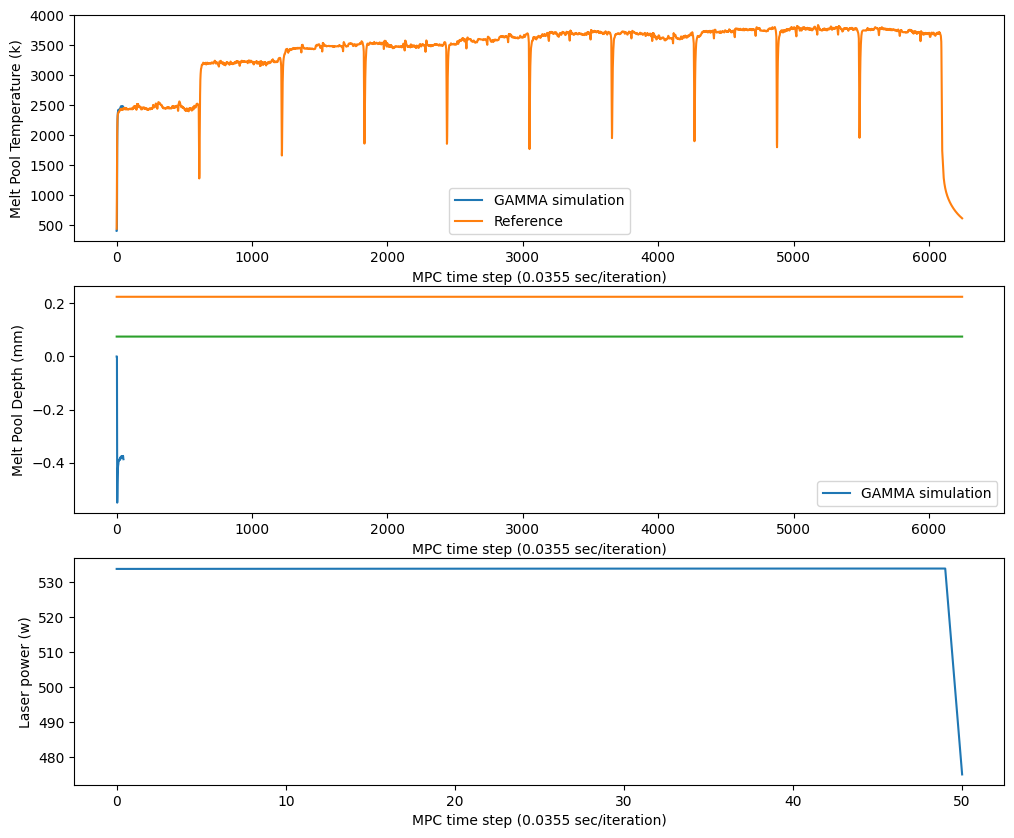

  2%|▏         | 101/6245 [00:12<12:14,  8.37it/s]


KeyboardInterrupt: 

In [10]:
# step #
P = 50
N_step = len(mp_temp_ref) - P


# initialize GAMMA class
GAMMA_class.ref = mp_temp_ref
GAMMA_class.fix_cov_all = fix_covariates
GAMMA_class.x_past = init_avg.clone()
GAMMA_class.u_past = laser_power_past.clone()

GAMMA_class.x_hat_current = GAMMA_class.x_past[:, -1]
GAMMA_class.x_sys_current = GAMMA_class.x_past[:, -1].reshape(2, 1)

GAMMA_class.x_past_save = GAMMA_class.x_past.T.clone()
GAMMA_class.u_past_save = GAMMA_class.u_past.clone()
GAMMA_class.MPC_counter = window 


# execution loop
from tqdm import tqdm

for i in tqdm(range(N_step)):
    run_one_step_policy(GAMMA_class, model, P=P, window=window)

    if i % 1000 == 0:
        plot_fig(GAMMA_class, N_step)
